In [1]:
import os,sys,time
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from shutil import copy as cp
from glob import glob
import RealSim_IFS


## Information on SDSS-IV MaNGA data

Data Access: https://www.sdss.org/dr16/manga/manga-data/data-access/ 

Data Model: https://www.sdss.org/dr14/manga/manga-data/data-model/

In this test, I download a MaNGA `RSS` file (row-reduced spectra) and generate a cube using `RealSim-IFS`. I then compare the output with the MaNGA DRP `CUBE` for the same object. The output should be similar apart from factors such as astrometric corrections, differential atmospheric refraction (DAR), which are accounted for to ~0.1 arcsec accuracy by the MaNGA DRP.

In [2]:
if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
    wdir = os.environ['SLURM_TMPDIR']
    os.chdir(wdir)
    print(os.getcwd())

/localscratch/bottrell.35790436.0


## Get file from science archive server

Using the `rsync` method.

In [29]:

sas_base_dir = 'rsync://data.sdss.org/dr16/manga/spectro/redux/v2_4_3'

plate = 7443
ifudesign = 12703

filename = 'manga-{PLATE}-{IFUDESIGN}-LINRSS.fits.gz'.format(PLATE=plate,IFUDESIGN=ifudesign)
target_url = '{}/{}/stack/{}'.format(sas_base_dir,plate,filename)

if not os.access(filename,0):
    rsync_cmd = 'rsync -avz --info=progress2 {} ./{}'.format(target_url,filename)
    start = time.time()
    os.system(rsync_cmd)
    print(time.time()-start)
   

1432.5272483825684


## Move file to local scratch

(working directory) and unzip. 

In [3]:
data_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Data'

plate = 7443
ifudesign = 12703

filename = 'manga-{PLATE}-{IFUDESIGN}-LINRSS.fits.gz'.format(PLATE=plate,IFUDESIGN=ifudesign)

if not os.access('{}/{}'.format(wdir,filename),0):
    cp('{}/{}'.format(data_dir,filename),wdir)

os.system('gunzip -f {}'.format(filename))


0

## File exploration

https://data.sdss.org/datamodel/files/MANGA_SPECTRO_REDUX/DRPVER/PLATE4/stack/manga-RSS.html

Note that dimension 0 of the `FLUX` data in the `rss` file is 1905 which is an integer multiple of 127 fibers and 3 dithered exposures. The other dimension is `Nels` (the number of spectral elements).

Below I show a single spectrum. The wavelength array for all spectra is in the `WAVE` HDU.

/scratch/bottrell/Merger_Kinematics/Venv/p37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/scratch/bottrell/Merger_Kinematics/Venv/p37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


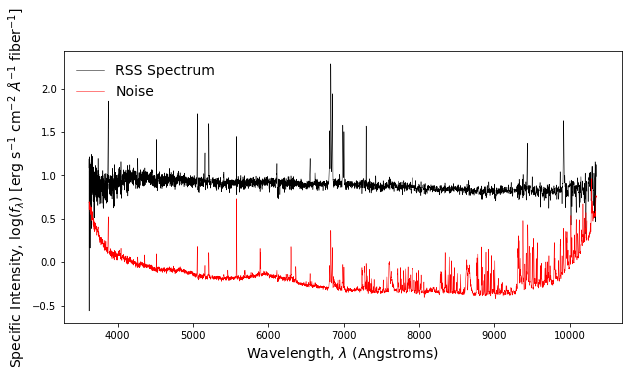

In [4]:
rssname = filename.replace('.gz','')

hdu = fits.open(rssname)

rss = hdu['FLUX'].data
lam = hdu['WAVE'].data
isigma = np.sqrt(hdu['IVAR'].data)
sigma = 1./isigma

# find appropriate spectrum for plotting
sums = np.nansum(rss,axis=1)
index = np.argmax(sums)+3

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(lam,np.log10(rss[index]),c='black',linewidth=0.5,label='RSS Spectrum')
ax.plot(lam,np.log10(sigma[index]),c='red',linewidth=0.5,label='Noise')
ax.set_xlabel(r'Wavelength, $\lambda$ (Angstroms)',fontsize=14)
ax.set_ylabel(r'Specific Intensity, $\log(f_{\lambda})$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$ fiber$^{-1}$]',fontsize=14)
ax.legend(frameon=False,loc='upper left',fontsize=14)

## The `OBSINFO` Extension

The `OBSINFO` extension contains information about each exposure. First, note that the shape of data in this extension is 15 -- corresponding to the $5 \times 3$ dithered exposures taken. One thing in which we are interested is the guide-star seeing (arcsec) before convolution with the instrument. There are 15 values, one for each exposure. We could appropriately take the median seeing of these exposures and apply it to the input data cubes with using a kernel constructed from two Gaussian profiles:

9/13 * Gaussian(FWHM = Theta) + 4/13 * Gaussian(FWHM = 2 * Theta) where Theta = SEEING/1.05

There is a weak FWHM$(\lambda)$ = FWHM$_{5000A} \times (\lambda\;/\;5000A)^{-0.2}$ 

where FWHM$_{5000A}$ is the Full Width at Half Maximum at 5000 Angstroms reported in the `OBSINFO` file.

In [5]:
obsinfo = hdu['OBSINFO']
exp_seeing = obsinfo.data['SEEING']

lam = 6000 # angstrom

seeing5000A = np.median(exp_seeing)

def seeing(seeing5000A,lam):
    return seeing5000A * (lam/5000)**(-0.2)

fwhm_lam = seeing(seeing5000A, lam)
print(fwhm_lam)


1.5858169999624556


## The `XPOS` and `YPOS` Extensions

These provide the effective wavelength dependent x and y positions of the all fiber centroids from each exposure accounting for DAR and other astrometry effects. In the left panel, note the slight irregularities in the median position of the fibers computed over all wavelength elements. Corrections which account for these position offsets are made in the MaNGA DRP and are illustrated in the right panel. The blue circles are the "effective" fiber positions in the first wavelength element for a single exposure. The green and red are the corresponding "effective" positions in the 1000th and last wavelength element.

For deep learning applications, the slight counter-clockwise rotation of the pattern can be accounted for with augmentation. Rotations are also allowed as part of `RealSim-IFS`'s `MaNGA_Observe` method.

(1905, 6732)


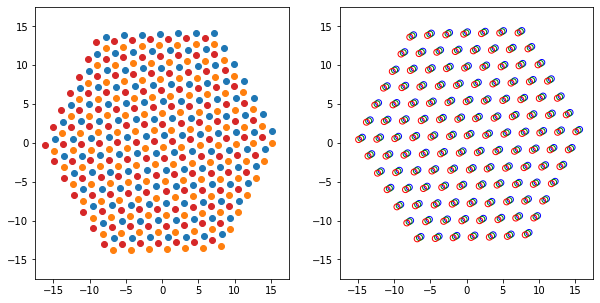

In [27]:
xpos = hdu['XPOS'].data
ypos = hdu['YPOS'].data
print(xpos.shape)

med_xpos = np.median(xpos,axis=1)
med_ypos = np.median(ypos,axis=1)
lam_index = 1000

fig,axarr = plt.subplots(1,2,figsize=(10,5))

ax = axarr[0]
ax.scatter(med_xpos[:127],med_ypos[:127],color = 'C0')
ax.scatter(med_xpos[127:2*127],med_ypos[127:2*127],color = 'C1')
ax.scatter(med_xpos[2*127:3*127],med_ypos[2*127:3*127],color = 'C3')

ax = axarr[1]
ax.scatter(xpos[:127,0],ypos[:127,0],facecolor = 'None',edgecolor='blue')
ax.scatter(xpos[:127,lam_index],ypos[:127,lam_index],facecolor = 'None',edgecolor='green')
ax.scatter(xpos[:127,-1],ypos[:127,-1],facecolor = 'None',edgecolor='red')

for ax in axarr.flat:
    ax.set_xlim(-17.5,17.5)
    ax.set_ylim(-17.5,17.5)

## Overlaying the `RealSim-IFS` "idealized" fiber core positions

Because there are no chromatic refraction effects implemented in `RealSim-IFS` (operating under the assumption that the observational pipelines handle these effects reasonably well), there is no wavelength dependence to the positions of the fibers. There are also no measurement/precision errors in the positions of the fibers. The fiber positions are determined analytically. Implementing such errors would be far from trivial. Gaussian errors, for example, would not capture the systematic effect on the position of a given fiber by the imprecision in the position of another fiber or from DAR for that matter.

Nonetheless, it is clear that the code produces the correct IFU dimensions and intended pattern for MaNGA. The procedures for handling the these effects DRP should make the "realism" of these synthetic observations compatible.

(-17.5, 17.5)

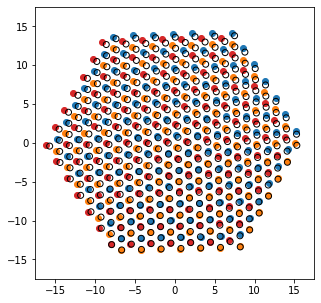

In [29]:
import RealSim_IFS

(xc_arr,yc_arr),params = RealSim_IFS.MaNGA_Observe(bundle_name='N127',
                                           fibers_per_side=None,
                                           n_observations='Classic',
                                           rotation_degrees = 1.5,
                                           return_params=True)

fiber_diameter_arcsec = params['fiber_diameter_arcsec']
core_diameter_arcsec = params['core_diameter_arcsec']
n_observations = xc_arr.shape[-1]

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(med_xpos[:127],med_ypos[:127],color = 'C0')
ax.scatter(med_xpos[127:2*127],med_ypos[127:2*127],color = 'C1')
ax.scatter(med_xpos[2*127:3*127],med_ypos[2*127:3*127],color = 'C3')

ax.scatter(xc_arr[:,0],yc_arr[:,0],facecolor = 'None',edgecolor='black')
ax.scatter(xc_arr[:,1],yc_arr[:,1],facecolor = 'None',edgecolor='black')
ax.scatter(xc_arr[:,2],yc_arr[:,2],facecolor = 'None',edgecolor='black')

ax.set_xlim(-17.5,17.5)
ax.set_ylim(-17.5,17.5)


## Comparison of output from the MaNGA DRP and RealSim-IFS

The input data are the spectra from the RSS files. Because the positions of the fibers in the real data have wavelength-dependent corrections, I will use the median position of the fibers over all wavelenghts for the observational data. The output cube has 0.5 arcsec per pixel.


MemoryError: Unable to allocate array with shape (1905, 6732, 72, 72) and data type float64

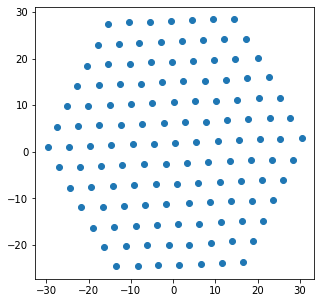

In [52]:
input_grid_dims = 36
out_arcsec_per_pixel = 0.5
output_grid_dims = int(input_grid_dims/out_arcsec_per_pixel)
diam_cores_arcsec = 2. 

core_x_pixels,core_y_pixels,core_diameter_pixels = RealSim_IFS.Change_Coords(med_xpos,med_ypos,diam_cores_arcsec,
                                                                 input_grid_dims=input_grid_dims,
                                                                 output_grid_dims=output_grid_dims)

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(core_x_pixels[:127],core_y_pixels[:127])

out_cube,weight_map = RealSim_IFS.Fiber_to_Grid(rss,core_x_pixels,core_y_pixels,core_diameter_pixels,
                                                grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                                                gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                                rlim_pixels=1.6/out_arcsec_per_pixel)